82.01011967658997


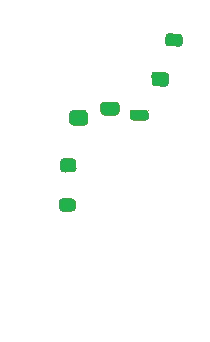

In [7]:
from PIL import Image
import numpy as np
import math
import matplotlib.pyplot as plt
import paho.mqtt.client as mqttClient
import time

#declaracion de variables conversion RGB-HSV-RGB para encontrar markers color verde en cuerpo


timein = time.time()
ImgRGB = np.array(Image.open('/home/xilinx/jupyter_notebooks/Proyecto_IIMAS/Imagenes/imagen1.jpg'))
Fils,Cols,NumMatrix = ImgRGB.shape
NImgRGB = np.zeros((Fils,Cols, NumMatrix), int)
HSV = np.zeros((Fils,Cols,NumMatrix),dtype = float)
RGB = np.zeros((Fils,Cols,NumMatrix),dtype = np.uint8)


#######          declaracion de variables algoritmo median filter       ######


Ventana = np.zeros(9,dtype = np.uint8)


###### #         declaracion de variables algoritmo erode               #######


F = 2;C = F;
LimVent_i = F+1; LimVent_j = C+1;
#global I2;
I2 = np.zeros((Fils,Cols),dtype = int)


####   declaracion de variables algoritmo Connected-component labeling  ####


Componente = 0
global Etiqueta;
Etiqueta = np.zeros((Fils,Cols),dtype = np.uint8)
####global I;
I = np.zeros((Fils,Cols),dtype = np.uint8)
####variables para encontrar centroide
Sum_i = np.zeros(7,dtype = np.uint32)
Sum_j = np.zeros(7,dtype = np.uint32)
Ci = np.zeros(7,dtype = np.uint32)
Cj = np.zeros(7,dtype = np.uint32)
NumPxl = np.zeros(7,dtype = np.uint32)


##################              rgb_to_hsv fuction       ###################


def RGB_A_HSV(r,g,b):
    r = r/255
    g = g/255
    b = b/255
####vALOR MAXIMO
    mx = r
    if g > mx:
        mx = g
        if b > mx:
            mx = b        
#####VALOR MINIMO
    mn = r
    if g < mn:
        mn = g
        if b < mn:
            mn = b
#####CONVERSION
    df = mx-mn
    if mx == mn:
        h = 0
    elif mx == r:
        h = (60*((g-b)/df) + 360)%360
    elif mx == g:
        h = (60*((b-r)/df) + 120)%360
    elif mx == b:
        h = (60*((r-g)/df) + 240)%360

    if mx == 0:
        s = 0
    else:
        s = df/mx
    h = h/2#de 0-360 a 0-180
    s = s*255#de 0-1 a 0-255
    v = mx*255#de 0-1 a 0-255
    return h,s,v


#####################              sort function             ###############


def Ordenar(Arreglo,Tamaño):
    for k in range(1,Tamaño):
        key = Arreglo[k]
        p = k-1
        while p >= 0 and Arreglo[p] > key: 
            Arreglo[p + 1] = Arreglo[p] 
            p = p - 1
        Arreglo[p + 1] = key
        
        
##################              hsv_to_rgb fuction       ###################


def hsv_to_rgb(h,s,v):
    h = h*2
    s = s/255
    v = v/255
    hsix = h/60
    hsixf = math.floor(hsix)
    hi = int(hsixf)%6
    f = hsix-hsixf;
    p = v*(1-s)
    q = v*(1-f*s)
    t = v*(1-(1-f)*s)
    r, g, b = 0, 0, 0 
    if hi == 0:
        r, g, b = v, t, p
    elif hi == 1:
        r, g, b = q, v, p
    elif hi == 2:
        r, g, b = p, v, t
    elif hi == 3:
        r, g, b = p, q, v
    elif hi == 4:
        r, g, b = t, p, v
    elif hi == 5:
        r, g, b = v, p, q    
    r, g, b = int(r*255), int(g*255), int(b*255)
    return r, g, b


############              conected component labeling function           ######


def CCL(x,y,c):
    global Etiqueta
    global I2
    dx = np.array([-1,0,1,1,1,0,-1,-1])
    dy = np.array([1,1,1,0,-1,-1,-1,0])
    Etiqueta[x,y] = c
    for i in range(0,8):
        nx = x+dx[i]
        ny = y+dy[i]
        if I2[nx,ny] and not(Etiqueta[nx,ny]):
            CCL(nx,ny,c)
    return   


##############      connect to broker (cloudmqtt)   ########################


def on_connect(client, userdata, flags, rc):
 
    if rc == 0:
 
        print("Connected to broker")
 
        global Connected                #Use global variable
        Connected = True                #Signal connection 
 
    else:
 
        print("Connection failed")


#########################            cosine law        ########################


def LeyCosenos(D):
    #distancia entre dos puntos 
    a = math.sqrt(pow(int(D[0])-int(D[1]),2)+pow(int(D[3])-int(D[4]),2))
    b = math.sqrt(pow(int(D[0])-int(D[2]),2)+pow(int(D[3])-int(D[5]),2))
    c = math.sqrt(pow(int(D[1])-int(D[2]),2)+pow(int(D[4])-int(D[5]),2))
    #ley de cosenos para encontrar angulos
    num1 = pow(a,2)-pow(b,2)-pow(c,2)
    dem1 = -2*b*c
    A = math.acos(num1/dem1)
    A = math.degrees(A)
    num2 = pow(b,2)-pow(a,2)-pow(c,2)
    dem2 = -2*a*c
    B = math.acos(num2/dem2)
    B = math.degrees(B)
    num3 = pow(c,2)-pow(a,2)-pow(b,2)
    dem3 = -2*a*b
    C = math.acos(num3/dem3)
    C = math.degrees(C)     
    return a, b, c, A, B, C       

        
###      loop de llamado de funciones para encontrar color verde       #####
###############               y de binarizacion        #####################


for i in range(0,Fils):
    for j in range(0,Cols):
#####llamado de funcion rgb_to_hsv           
        Rd, Gn, Bl = ImgRGB[i,j,0], ImgRGB[i,j,1], ImgRGB[i,j,2]

        HSV[i,j,0], HSV[i,j,1], HSV[i,j,2] = RGB_A_HSV(Rd, Gn, Bl)
#####umbral en componentes h,s,v para filtrar color verde            
        if HSV[i,j,0] >= 25 and HSV[i,j,0] <= 110 and HSV[i,j,1] >= 110 and HSV[i,j,1] <= 255  and HSV[i,j,2] >= 140 and HSV[i,j,2] <= 255:
            HSV[i,j,0], HSV[i,j,1], HSV[i,j,2] = HSV[i,j,0], HSV[i,j,1], HSV[i,j,2]
        else:
            HSV[i,j,0], HSV[i,j,1], HSV[i,j,2] = 0, 0, 255
#####llamado de funcion hsv_to_rgb
        RGB[i,j,0], RGB[i,j,1], RGB[i,j,2] = hsv_to_rgb(HSV[i,j,0], HSV[i,j,1], HSV[i,j,2])
#####conversion a imagen binaria            
        if RGB[i,j,1] == 255:
            I[i,j] = 0;
        else:
            I[i,j] = 255;


######################         loop median filter       ####################


for i in range(0,Fils):
    for j in range(0,Cols):
        if i > 0 and i < Fils-1 and j > 0 and j < Cols-1:
            Ventana[0] = I[i-1,j-1]
            Ventana[1] = I[i-1,j] 
            Ventana[2] = I[i-1,j+1] 
            Ventana[3] = I[i,j-1] 
            Ventana[4] = I[i,j] 
            Ventana[5] = I[i,j+1] 
            Ventana[6] = I[i+1,j-1] 
            Ventana[7] = I[i+1,j]
            Ventana[8] = I[i+1,j+1]
            Ordenar(Ventana,9)
            I[i,j] = Ventana[4]
            

##########################      loop erode algorithm    ##################### 


for i in range(0,Fils):
    for j in range(0,Cols):        
        if i > LimVent_i and i < Fils-F and j > LimVent_j and j < Cols-C: #para ventana de 5x5  
            Mn =I[i,j]
            Mx = Mn            
            for i1 in range(i-LimVent_i,i+LimVent_i):
                for j1 in range(j-LimVent_j,j+LimVent_j):
                    if Mn > I[i1,j1]:
                        Mn = I[i1,j1]                        
            I2[i,j] = Mn


###################   loop conected component labeling  ######################
################     variables para encontrar centroide #####################


for i in range(0,Fils):
    for j in range(0,Cols):
        if I2[i,j] and not(Etiqueta[i,j]):
            Componente = Componente+1
            CCL(i,j,Componente)
            #if label[i,j] == 3
            #    disp[i]
            #    disp[j]            
        if Etiqueta[i,j] == 1:
            NumPxl[0] = NumPxl[0]+1
            Sum_i[0] = Sum_i[0] + i
            Sum_j[0] = Sum_j[0] + j
            Ci[0] = round(Sum_i[0]/NumPxl[0])
            Cj[0] = round(Sum_j[0]/NumPxl[0])   
        elif Etiqueta[i,j] == 2:
            NumPxl[1] = NumPxl[1]+1
            Sum_i[1] = Sum_i[1] + i
            Sum_j[1] = Sum_j[1] + j
            Ci[1] = round(Sum_i[1]/NumPxl[1])
            Cj[1] = round(Sum_j[1]/NumPxl[1])
        elif Etiqueta[i,j] == 3:
            NumPxl[2] = NumPxl[2]+1
            Sum_i[2] = Sum_i[2] + i
            Sum_j[2] = Sum_j[2] + j
            Ci[2] = round(Sum_i[2]/NumPxl[2])
            Cj[2] = round(Sum_j[2]/NumPxl[2])
        elif Etiqueta[i,j] == 4:
            NumPxl[3] = NumPxl[3]+1
            Sum_i[3] = Sum_i[3] + i
            Sum_j[3] = Sum_j[3] + j
            Ci[3] = round(Sum_i[3]/NumPxl[3])
            Cj[3] = round(Sum_j[3]/NumPxl[3])
        elif Etiqueta[i,j] == 5:
            NumPxl[4] = NumPxl[4]+1
            Sum_i[4] = Sum_i[4] + i
            Sum_j[4] = Sum_j[4] + j
            Ci[4] = round(Sum_i[4]/NumPxl[4])
            Cj[4] = round(Sum_j[4]/NumPxl[4])
        elif Etiqueta[i,j] == 6:
            NumPxl[5] = NumPxl[5]+1
            Sum_i[5] = Sum_i[5] + i
            Sum_j[5] = Sum_j[5] + j
            Ci[5] = round(Sum_i[5]/NumPxl[5])
            Cj[5] = round(Sum_j[5]/NumPxl[5])
        elif Etiqueta[i,j] == 7:
            NumPxl[6] = NumPxl[6]+1
            Sum_i[6] = Sum_i[6] + i
            Sum_j[6] = Sum_j[6] + j
            Ci[6] = round(Sum_i[6]/NumPxl[6])
            Cj[6] = round(Sum_j[6]/NumPxl[6])
            
timefin = time.time()
print(timefin-timein)

imagen = np.zeros((Fils,Cols),dtype = np.uint8)
imagen = Image.fromarray(RGB)            

imagen